In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lib.occupancy import compute_occupancy, estimate_rate_occupancy

# Paths
fails_path_run3 = "1_data/df3_valid.csv"
beam_path_run3 = "1_data/beam3.csv"
fails_path_run2 = "1_data/df2_valid.csv"
beam_path_run2 = "1_data/beam2.csv"

def load_and_prep_data(fails_path, beam_path):
    print(f"Loading {fails_path} and {beam_path}...")
    fails = pd.read_csv(fails_path)
    beam = pd.read_csv(beam_path)
    
    # Convert time columns
    fails['time'] = pd.to_datetime(fails['time'])
    beam['time'] = pd.to_datetime(beam['time'])
    
    # Sort
    fails = fails.sort_values('time')
    beam = beam.sort_values('time')
    
    # Ensure beam_on is boolean
    beam['beam_on'] = beam['beam_on'].astype(bool)
    
    return fails, beam

# both runs
fails_2, beam_2 = load_and_prep_data(fails_path_run2, beam_path_run2)
print(f"Loaded {len(fails_2)} fails and {len(beam_2)} beam records.")

fails_3, beam_3 = load_and_prep_data(fails_path_run3, beam_path_run3)
print(f"Loaded {len(fails_3)} fails and {len(beam_3)} beam records.")

# --- merging ---

# Merge fails with beam data (backward search to find the latest beam status)
fails_merged_2 = pd.merge_asof(fails_2, beam_2, on='time', direction='backward')
fails_merged_3 = pd.merge_asof(fails_3, beam_3, on='time', direction='backward')

# Filter for Beam ON
fails_on_2 = fails_merged_2[fails_merged_2['beam_on'] == True].copy()
fails_on_3 = fails_merged_3[fails_merged_3['beam_on'] == True].copy()

print(f"Fails total: {len(fails_2)}")
print(f"Fails total: {len(fails_3)}")
print(f"Fails with Beam ON: {len(fails_on_2)}")
print(f"Fails with Beam ON: {len(fails_on_3)}")


Loading 1_data/df2_valid.csv and 1_data/beam2.csv...
Loaded 1030123 fails and 9999 beam records.
Loading 1_data/df3_valid.csv and 1_data/beam3.csv...
Loaded 1081006 fails and 9997 beam records.
Fails total: 1030123
Fails total: 1081006
Fails with Beam ON: 745684
Fails with Beam ON: 1070425


In [2]:
fails_on_2.head(
)

,Unnamed: 0_x,time,lfsrTMR,B0,B1,B2,B3,fails_inst,fails_acum,bitn0,...,N1MeV,run_group,dt,dTID,dHEH,dN1MeV,TID_dose_rate,N1MeV_dose_rate,HEH_dose_rate,beam_on
0,0,2022-09-14 11:35:48.885571,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True
1,1,2022-09-14 11:35:49.306446,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True
2,2,2022-09-14 11:35:49.727205,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True
3,3,2022-09-14 11:35:50.135328,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True
4,4,2022-09-14 11:35:50.556157,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True


## Types of radiation and errors
Given that in this notebook we will be analyzing the errors produced by radiation, considering bit flips inside a TMR system. We need to consider that we are able to perform analysis of the device on its useful life time.

### Types of radiation
- TID: Ionizing radiation wich causes slowly a permanent change in the device.
- HEH: High energy hadrons wich may cause Single Event Upsets or Latch-Ups
- N1Mev: Considering equivalent of neutrons, may cause damage in the structure of the material inside the chip, also an slow permanent damage.


### Types of errors in this notebook
Here it was only considered the type of error relating to bit flips, current data may be included for latch ups, but prefered to do separetly.
SEU: produced by a single energy particle which ionizes the structure and allows to consider errors in the memory.

In [3]:
flux_2 = beam_2[beam_2["beam_on"]==True]["HEH_dose_rate"]
flux_2.tail()

9994    410782.310225
9995    477192.049784
9996    456753.282732
9997    431277.865709
9998    499518.557405
Name: HEH_dose_rate, dtype: float64

In [4]:
flux_3 = beam_3[beam_3["beam_on"]==True]["HEH_dose_rate"]
flux_3.head()

20    354295.994985
21    401166.101912
22    519625.342777
23    475424.521020
24    401264.213296
Name: HEH_dose_rate, dtype: float64

## 1. Concatenate Data and Prepare
Better to separate the data on bathcs

In [5]:

# Concatenate Fails
# fails_on = pd.concat([fails_on_2, fails_on_3]).sort_values('time').reset_index(drop=True)
fails_on = fails_on_3

In [6]:

# Calculate dt (time difference between samples)
fails_on['dt'] = fails_on['time'].diff().dt.total_seconds().fillna(0)

# Ensure HEH_dose_rate is present (it should be from the merge)
# If there are NaNs in dose rate (e.g. from backward merge gaps), fill with 0 or interpolate
fails_on['HEH_dose_rate'] = fails_on['HEH_dose_rate'].fillna(0)

print(f"Total Combined Beam ON samples: {len(fails_on)}")
fails_on.head()


Total Combined Beam ON samples: 1070425


,Unnamed: 0_x,time,lfsrTMR,B0,B1,fails_inst,fails_acum,bitn0,bitnP0,bitn1,...,N1MeV,run_group,dt,dTID,dHEH,dN1MeV,TID_dose_rate,N1MeV_dose_rate,HEH_dose_rate,beam_on
2151,2151,2022-11-09 12:12:59.715422,0,FF00,FF00,0,0,0,0,0,...,7.002708e+08,3,0.000000,0.017444,3.288283e+07,1.611010e+08,0.000342,3.155447e+06,644068.000856,True
2152,2152,2022-11-09 12:13:00.132584,0,FF00,FF00,0,0,0,0,0,...,7.002708e+08,3,0.417162,0.017444,3.288283e+07,1.611010e+08,0.000342,3.155447e+06,644068.000856,True
2153,2153,2022-11-09 12:13:00.571005,0,FF00,FF00,0,0,0,0,0,...,7.002708e+08,3,0.438421,0.017444,3.288283e+07,1.611010e+08,0.000342,3.155447e+06,644068.000856,True
2154,2154,2022-11-09 12:13:00.988842,0,FF00,FF00,0,0,0,0,0,...,7.002708e+08,3,0.417837,0.017444,3.288283e+07,1.611010e+08,0.000342,3.155447e+06,644068.000856,True
2155,2155,2022-11-09 12:13:01.410444,0,FF00,FF00,0,0,0,0,0,...,7.002708e+08,3,0.421602,0.017444,3.288283e+07,1.611010e+08,0.000342,3.155447e+06,644068.000856,True


In [19]:
print(fails_on.columns)

Index(['Unnamed: 0_x', 'time', 'lfsrTMR', 'B0', 'B1', 'fails_inst',
       'fails_acum', 'bitn0', 'bitnP0', 'bitn1', 'bitnP1', 'bitn2', 'bitnP2',
       'bitn3', 'bitnP3', 'bitn4', 'bitnP4', 'bitn5', 'bitnP5', 'bitn6',
       'bitnP6', 'bitn7', 'bitnP7', 'bitn8', 'bitnP8', 'bitn9', 'bitnP9',
       'bitn10', 'bitnP10', 'bitn11', 'bitnP11', 'bitn12', 'bitnP12', 'bitn13',
       'bitnP13', 'bitn14', 'bitnP14', 'bitn15', 'bitnP15', 'failsP_acum',
       'Unnamed: 0_y', 'TID', 'HEH', 'N1MeV', 'run_group', 'dt', 'dTID',
       'dHEH', 'dN1MeV', 'TID_dose_rate', 'N1MeV_dose_rate', 'HEH_dose_rate',
       'beam_on'],
      dtype='object')


## 2. Extract Reset Interval
We analyze `fails_inst` to determine the reset interval. We look for points where the value drops significantly (resets).

Median Reset Interval: 1.68 s


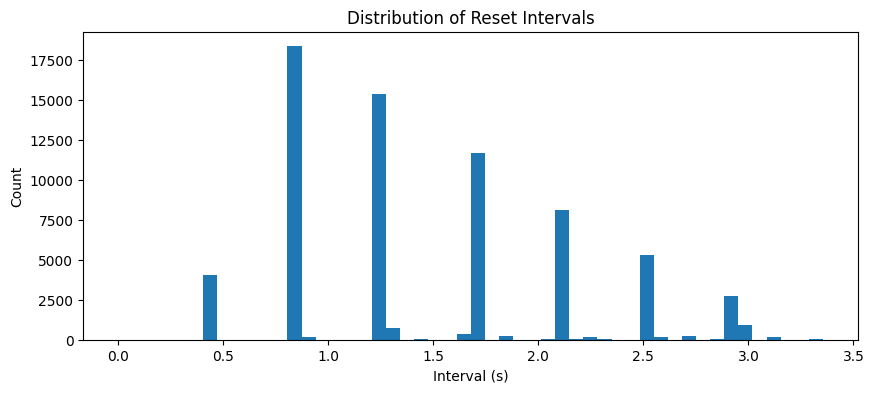

In [7]:

def find_reset_interval(df, col='fails_inst'):
    # Detect resets: where current value is less than previous value
    # We assume fails_inst is cumulative between resets
    
    resets = df[df[col] < df[col].shift(1)]
    
    if len(resets) < 2:
        print("Not enough resets detected to estimate interval.")
        return 60 # Default fallback
        
    # Calculate time differences between resets
    reset_times = resets['time']
    intervals = reset_times.diff().dt.total_seconds().dropna()
    
    # Filter out very small intervals (noise) or very large ones (beam off gaps)
    # We assume the reset interval is somewhat regular
    median_interval = intervals.median()
    
    print(f"Median Reset Interval: {median_interval:.2f} s")
    
    # Plot to verify
    plt.figure(figsize=(10, 4))
    plt.hist(intervals, bins=50, range=(0, median_interval*2))
    plt.title("Distribution of Reset Intervals")
    plt.xlabel("Interval (s)")
    plt.ylabel("Count")
    plt.show()
    
    return median_interval

reset_interval = find_reset_interval(fails_on)


## 3. Flux-Based Analysis
We calculate $\lambda$ and Cross Section $\sigma$ over time windows $W$.

In [ ]:
import numpy as np
import pandas as pd

def analyze_cross_section_robust(df, reset_interval_s, window_width_s=60):
    """
    Calcula la sección eficaz (Sigma) aplicando corrección de ocupancia y
    propagación de errores, usando lógica vectorizada.
    
    Params:
        df: DataFrame con columnas ['time', 'fails_inst', 'dHEH', 'beam_on']
        reset_interval_s: Tiempo T del mecanismo Reset-Latch (ej. 0.1s)
        window_width_s: Ancho de la ventana de análisis (ej. 60s)
    """
    
    # 1. Preparación: Indexar por tiempo para resampling
    temp_df = df.set_index('time').copy()
    
    # 2. Resampling (Agrupación por ventanas de tiempo)
    # Calculamos las sumas y conteos necesarios en una sola pasada vectorizada
    # 'dHEH': Sumamos la fluencia incremental -> Fluencia Total en la ventana
    # 'fails_inst': Si es un latch binario (0/1), la suma es N_latched.
    #               Si es un contador acumulativo que se resetea, necesitamos diff().
    #               *Asumiendo que fails_inst marca 1 si hubo error en el intervalo*:
    # 'beam_on': Usamos la media para saber si el haz estuvo prendido (fracción de tiempo)
    # 'dt': Sumamos para tener la duración real (utile para validar)
    
    # Pre-cálculo: Asegurar que contamos eventos de latch
    # Si fails_inst es acumulativo, sacamos la diferencia positiva:
    # (Ajusta esta lógica según si tu columna es un flag o un contador)
    temp_df['is_latched'] = temp_df['fails_inst'].diff().fillna(0).clip(lower=0) > 0
    # O si 'fails_inst' es simplemente 1 cuando hay error y 0 si no:
    # temp_df['is_latched'] = temp_df['fails_inst'] > 0
    
    # Definir agregaciones
    resampled = temp_df.resample(f'{window_width_s}s').agg({
        'is_latched': ['sum', 'count'],  # sum=N_latched, count=N_total_intervals
        'dHEH': 'sum',                   # Fluencia total en la ventana
        'beam_on': 'mean'                # % del tiempo con haz on
    })
    
    # Aplanar columnas MultiIndex
    resampled.columns = ['n_latched', 'n_total_intervals', 'fluence_window', 'beam_fraction']
    
    # 3. Filtrado de Calidad
    # Solo analizar ventanas donde el haz estuvo encendido mayoritariamente (>50%)
    # y donde hay suficiente estadística de intervalos
    valid_windows = resampled[
        (resampled['beam_fraction'] > 0.5) & 
        (resampled['n_total_intervals'] > 0)
    ].copy()
    
    # 4. Cálculo de Ocupancia (Phi)
    valid_windows['phi'] = valid_windows['n_latched'] / valid_windows['n_total_intervals']
    
    # Evitar log(0) o log(negativo) si phi=1 (saturación total)
    # Usamos un techo de seguridad (ej. 0.999) o descartamos esas ventanas
    valid_windows['phi_clipped'] = valid_windows['phi'].clip(upper=0.999)
    
    # 5. Corrección de Ocupancia (Recuperar Lambda Real)
    # Lambda_corr = -ln(1 - phi) / T_reset
    # Nota: Esto da eventos por SEGUNDO (Hz) promedio en la ventana
    valid_windows['lambda_corr'] = -np.log(1 - valid_windows['phi_clipped']) / reset_interval_s
    
    # Calculo Naive para comparación (Eventos / Tiempo total observado)
    valid_windows['lambda_naive'] = valid_windows['n_latched'] / (valid_windows['n_total_intervals'] * reset_interval_s)

    # 6. Cálculo de Flujo Promedio en la Ventana
    # Flux = Fluence / Duration
    # Duration = n_total_intervals * reset_interval_s (aprox) o window_width_s
    valid_windows['flux_avg'] = valid_windows['fluence_window'] / window_width_s
    
    # 7. Cálculo de Cross Section (Sigma)
    # Sigma = Lambda_corr / Flux_avg
    valid_windows['sigma_corr'] = valid_windows['lambda_corr'] / valid_windows['flux_avg']
    
    # 8. Cálculo de Incertidumbre (Error Estándar)
    # Error en Lambda (propagación derivada en tu paper):
    # sigma_lambda = sqrt( phi / (T^2 * N * (1-phi)) )
    N = valid_windows['n_total_intervals']
    T = reset_interval_s
    phi = valid_windows['phi_clipped']
    
    term_variance = phi / ( (T**2) * N * (1 - phi) )
    valid_windows['lambda_err'] = np.sqrt(term_variance)
    
    # Error en Sigma (asumiendo error de flujo despreciable por ahora, o sumando 10%)
    # sigma_sigma = sigma_corr * (lambda_err / lambda_corr)
    valid_windows['sigma_err'] = valid_windows['sigma_corr'] * (valid_windows['lambda_err'] / valid_windows['lambda_corr'])
    
    return valid_windows[['lambda_naive', 'lambda_corr', 'lambda_err', 'flux_avg', 'sigma_corr', 'sigma_err']]

# Ejemplo de uso:
# results = analyze_cross_section_robust(df, reset_interval_s=0.01, window_width_s=60)

In [9]:

def analyze_flux_based(df, reset_interval, window_multiplier=100):
    window_size_s = reset_interval * window_multiplier
    print(f"Analysis Window Size: {window_size_s:.2f} s")
    
    start_time = df['time'].min()
    end_time = df['time'].max()
    
    results = []
    
    current_time = start_time
    while current_time < end_time:
        next_time = current_time + pd.Timedelta(seconds=window_size_s)
        
        # Get segment
        segment = df[(df['time'] >= current_time) & (df['time'] < next_time)].copy()
        
        if len(segment) > 1:
            # Calculate Total Fluence in this window
            # Fluence = Sum(Flux_j * dt_j)
            # Flux is in HEH/cm^2/s (assumed), dt is in s
            segment['fluence_step'] = segment['HEH_dose_rate'] * segment['dt']
            total_fluence = segment['fluence_step'].sum()
            
            # Calculate Total Fails
            # We need to reconstruct the cumulative count
            # diff = val[i] - val[i-1]
            # if diff < 0 (reset): add val[i] (assuming reset to 0 and val[i] is new accumulation)
            # else: add diff
            
            vals = segment['fails_inst'].values
            diffs = np.diff(vals, prepend=vals[0]) # Prepend to keep size
            
            # Correct for resets
            # If diff < 0, it means a reset happened. 
            # The 'lost' counts are the value just before reset. 
            # But simpler: just sum the positive increments? 
            # Or: if reset, the increment is just the new value (assuming it started at 0)
            
            # Let's try a robust way:
            # Reconstruct cumulative curve
            reconstructed = []
            cum_val = 0
            for i in range(1, len(vals)):
                d = vals[i] - vals[i-1]
                if d < 0:
                    # Reset
                    cum_val += vals[i] # Assume it reset to 0 and grew to vals[i]
                else:
                    cum_val += d
            
            total_fails = cum_val
            
            duration = segment['dt'].sum()
            
            if total_fluence > 0 and duration > 0:
                sigma = total_fails / total_fluence
                lam = total_fails / duration
                
                results.append({
                    'time': current_time,
                    'sigma': sigma,
                    'lambda': lam,
                    'fluence': total_fluence,
                    'fails': total_fails
                })
        
        current_time = next_time
        
    return pd.DataFrame(results)

# Run Analysis
results_df = analyze_flux_based(fails_on, reset_interval, window_multiplier=100)
results_df.head()


Analysis Window Size: 167.74 s


,time,sigma,lambda,fluence,fails
0,2022-11-09 12:12:59.715422,0.0,0.0,6.743121e+07,0
1,2022-11-09 12:15:47.454022,0.0,0.0,8.569770e+07,0
2,2022-11-09 12:18:35.192622,0.0,0.0,7.755156e+07,0
3,2022-11-09 12:21:22.931222,0.0,0.0,7.756646e+07,0
4,2022-11-09 12:24:10.669822,0.0,0.0,8.233055e+07,0


## 4. Results
We plot the estimated Cross Section and Failure Rate over time.

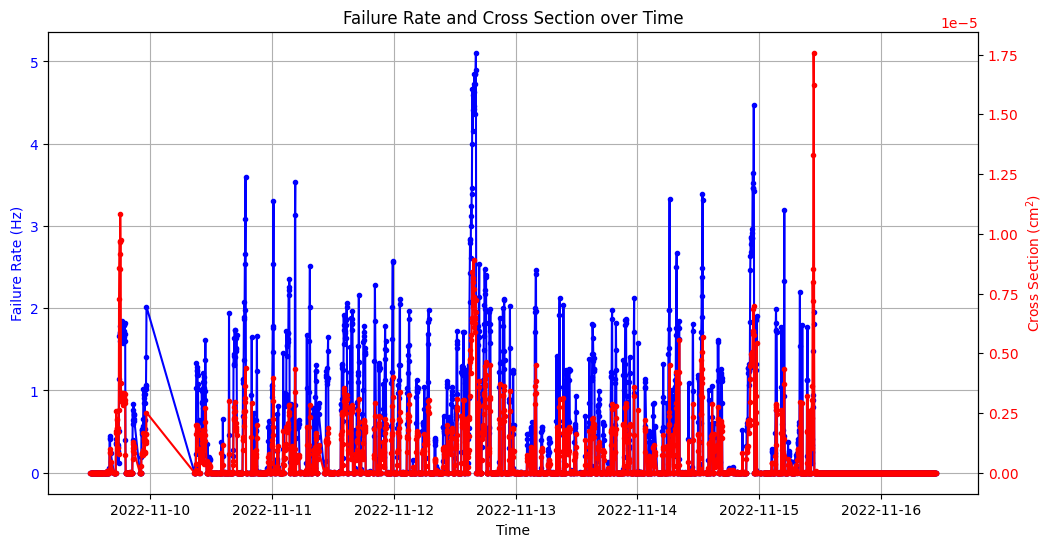

Mean Cross Section: 6.17e-07 cm^2
Mean Failure Rate: 0.3678 Hz


In [10]:

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Lambda
ax1.plot(results_df['time'], results_df['lambda'], 'b.-', label='Failure Rate $\lambda$ (Hz)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Failure Rate (Hz)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Plot Sigma on secondary axis
ax2 = ax1.twinx()
ax2.plot(results_df['time'], results_df['sigma'], 'r.-', label='Cross Section $\sigma$ (cm$^2$)')
ax2.set_ylabel('Cross Section (cm$^2$)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Failure Rate and Cross Section over Time')
plt.show()

# Statistics
print(f"Mean Cross Section: {results_df['sigma'].mean():.2e} cm^2")
print(f"Mean Failure Rate: {results_df['lambda'].mean():.4f} Hz")


## Visualizaciones alternativas
Eliminare ademas los sesgos de las regiones en los bordes, pues puede ocurrir un error relacionado a la ventana/apagado encendido del dispositivo.

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Asumimos que results_df ya está cargado
# 1. Convertir a datetime si no lo es
results_df['time'] = pd.to_datetime(results_df['time'])

# 2. PRE-PROCESAMIENTO: Cortar el 10% inicial y final (ajustable)
# Esto elimina el sesgo de los bordes que mencionaste
trim_pct = 0.10 
n_rows = len(results_df)
start_idx = int(n_rows * trim_pct)
end_idx = int(n_rows * (1 - trim_pct))

df_clean = results_df.iloc[start_idx:end_idx].copy()

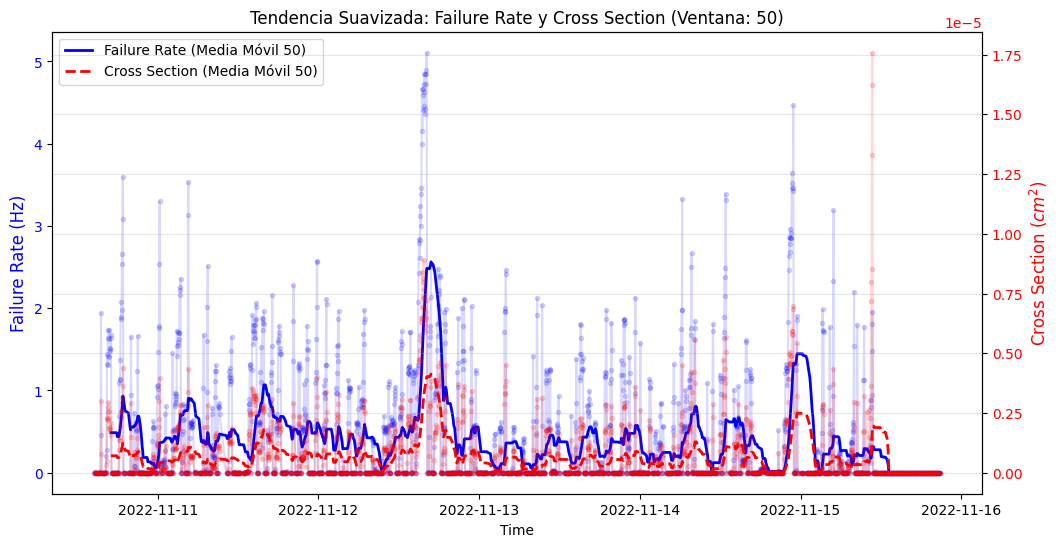

In [12]:
# Definir ventana de suavizado (ej. 50 puntos de datos, ajusta según tu frecuencia de muestreo)
window_size = 50 

fig, ax1 = plt.subplots(figsize=(12, 6))

# Eje 1: Failure Rate (Suavizado + Datos tenues de fondo)
alpha_value = 0.15
ax1.plot(df_clean['time'], df_clean['lambda'], 'b.-', alpha=alpha_value) # Ruido de fondo
ax1.plot(df_clean['time'], df_clean['lambda'].rolling(window=window_size).mean(), 
         color='blue', linewidth=2, label=f'Failure Rate (Media Móvil {window_size})')
ax1.set_xlabel('Time')
ax1.set_ylabel('Failure Rate (Hz)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Eje 2: Cross Section
ax2 = ax1.twinx()
ax2.plot(df_clean['time'], df_clean['sigma'], 'r.-', alpha=alpha_value) # Ruido de fondo
ax2.plot(df_clean['time'], df_clean['sigma'].rolling(window=window_size).mean(), 
         color='red', linewidth=2, linestyle='--', label=f'Cross Section (Media Móvil {window_size})')
ax2.set_ylabel('Cross Section ($cm^2$)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Leyenda unificada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

plt.title(f'Tendencia Suavizada: Failure Rate y Cross Section (Ventana: {window_size})')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Cross-section Correction (Occupancy Method)
We calculate the Naive Cross-section (biased) and the Corrected Cross-section using the occupancy method to account for saturation.

In [13]:

def calculate_cross_sections(results_df, reset_interval):
    print("Calculating Naive and Corrected Cross-sections...")
    
    # Total Latched Errors (N_l)
    # 'fails' in results_df is cumulative, so we take the last value.
    if len(results_df) == 0:
        print("No results to analyze.")
        return

    total_fails = results_df['fails'].iloc[-1]
    total_fluence = results_df['fluence'].sum()
    
    # 1. Naive Cross-section
    if total_fluence > 0:
        sigma_naive = total_fails / total_fluence
    else:
        sigma_naive = 0
        
    print(f"Total Fails (N_l): {total_fails}")
    print(f"Total Fluence: {total_fluence:.2e} particles/cm^2")
    print(f"Naive Cross-section: {sigma_naive:.2e} cm^2/device")
    
    # 2. Corrected Cross-section (Occupancy Method)
    # sigma_hat = - (1 / Phi_interval) * ln(1 - N_l / N_t)
    
    total_duration = results_df['time'].max() - results_df['time'].min()
    total_duration_s = total_duration.total_seconds()
    
    if total_duration_s <= 0 or reset_interval <= 0:
        print("Invalid duration or reset interval.")
        return

    N_t = total_duration_s / reset_interval
    N_l = total_fails
    
    occupancy = N_l / N_t
    
    print(f"Total Intervals (N_t) [Estimated]: {N_t:.0f}")
    print(f"Occupancy (phi = N_l / N_t): {occupancy:.4f}")
    
    sigma_corrected = 0
    if occupancy >= 1:
        print("Warning: Occupancy >= 1, saturation complete.")
        sigma_corrected = float('inf')
    else:
        avg_flux = total_fluence / total_duration_s
        phi_interval = avg_flux * reset_interval
        
        if phi_interval > 0:
            sigma_corrected = - (1 / phi_interval) * np.log(1 - occupancy)
        else:
            sigma_corrected = 0

    print(f"Corrected Cross-section: {sigma_corrected:.2e} cm^2/device")
    
    # 3. Comparison
    if sigma_naive > 0:
        divergence = (sigma_corrected - sigma_naive) / sigma_naive * 100
        print(f"Divergence: {divergence:.2f}%")
    
    if occupancy > 0.1:
        print("\n!!! High Occupancy Detected (>0.1) !!!")
        print("Significant divergence expected. Naive method underestimates the true rate.")
        
    return {
        'sigma_naive': sigma_naive,
        'sigma_corrected': sigma_corrected,
        'occupancy': occupancy,
        'divergence': divergence if sigma_naive > 0 else 0
    }

# Execute Correction
correction_results = calculate_cross_sections(results_df, reset_interval)


Calculating Naive and Corrected Cross-sections...
Total Fails (N_l): 0
Total Fluence: 3.40e+11 particles/cm^2
Naive Cross-section: 0.00e+00 cm^2/device
Total Intervals (N_t) [Estimated]: 357500
Occupancy (phi = N_l / N_t): 0.0000
Corrected Cross-section: -0.00e+00 cm^2/device


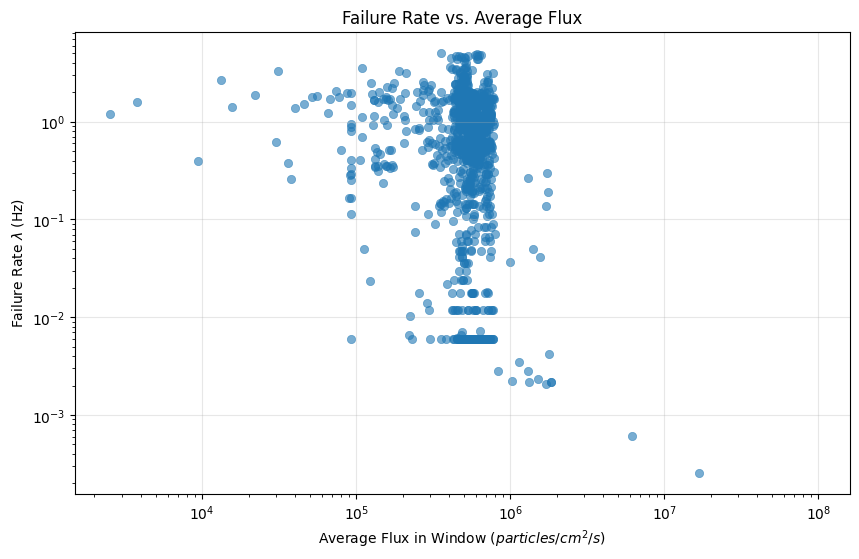

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'fluence' en results_df es la fluencia total en la ventana.
# Para obtener el flujo promedio, dividimos por la duración de la ventana.
# Asumiendo que la duración es aproximadamente constante (window_size_s).
window_duration = results_df['time'].diff().mean().total_seconds() # Estimación rápida
results_df['avg_flux'] = results_df['fluence'] / window_duration

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='avg_flux', y='lambda', alpha=0.6, edgecolor=None)
plt.xlabel('Average Flux in Window ($particles/cm^2/s$)')
plt.ylabel('Failure Rate $\lambda$ (Hz)')
plt.title('Failure Rate vs. Average Flux')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log') # Escala log-log para ver mejor rangos amplios
plt.show()

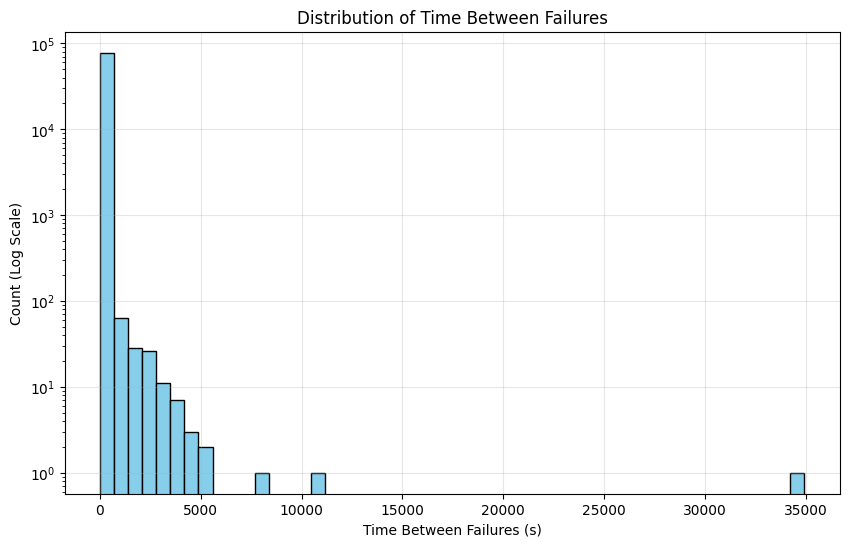

In [15]:
# Asumiendo que 'fails_on' tiene una entrada por cada latch positivo o que podemos filtrar los cambios
# Si fails_on es muestreo periódico, detectamos los flancos de subida en fails_acum
fail_events = fails_on[fails_on['fails_inst'].diff() > 0].copy() # Simplificación
fail_times = fail_events['time']
time_between_failures = fail_times.diff().dt.total_seconds().dropna()

plt.figure(figsize=(10, 6))
plt.hist(time_between_failures, bins=50, log=True, color='skyblue', edgecolor='black')
plt.xlabel('Time Between Failures (s)')
plt.ylabel('Count (Log Scale)')
plt.title('Distribution of Time Between Failures')
plt.grid(True, alpha=0.3)
plt.show()

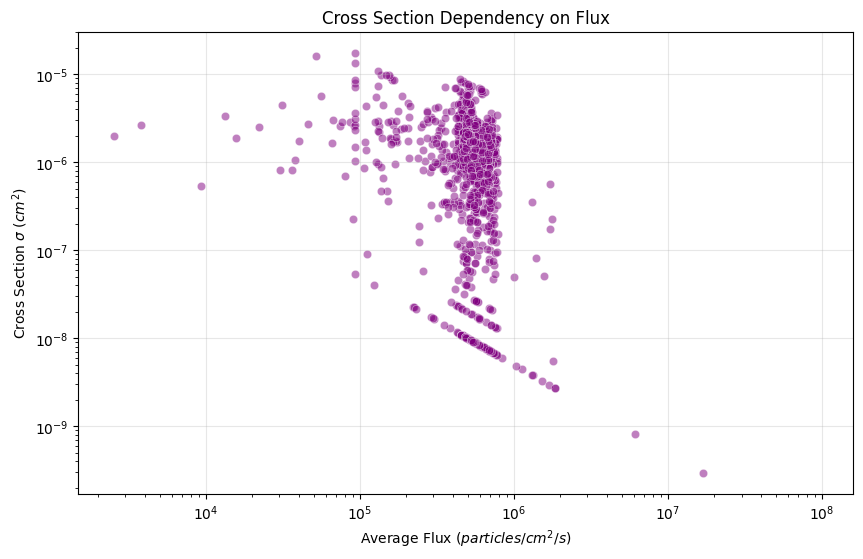

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='avg_flux', y='sigma', alpha=0.5, color='purple')
plt.xlabel('Average Flux ($particles/cm^2/s$)')
plt.ylabel('Cross Section $\sigma$ ($cm^2$)')
plt.title('Cross Section Dependency on Flux')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
# Si sigma es constante, debería verse como una línea horizontal con ruido.
plt.show()

Esta caída es una señal clásica de saturación o tiempo muerto no corregido. A flujos muy altos, el dispositivo o el sistema de adquisición está "ciego" durante una fracción significativa del tiempo, perdiendo eventos. Como $\sigma_{aparente} = \text{Tasa de Fallos} / \text{Flujo}$, si la tasa de fallos se satura (deja de crecer) mientras el flujo sigue aumentando, $\sigma$ disminuye artificialmente.

--- INICIANDO ANÁLISIS DE SECCIÓN EFICAZ CON CORTE DE CALIDAD ---
Criterio de Corte (Flux Crit): 5.0e+05 p/cm²/s


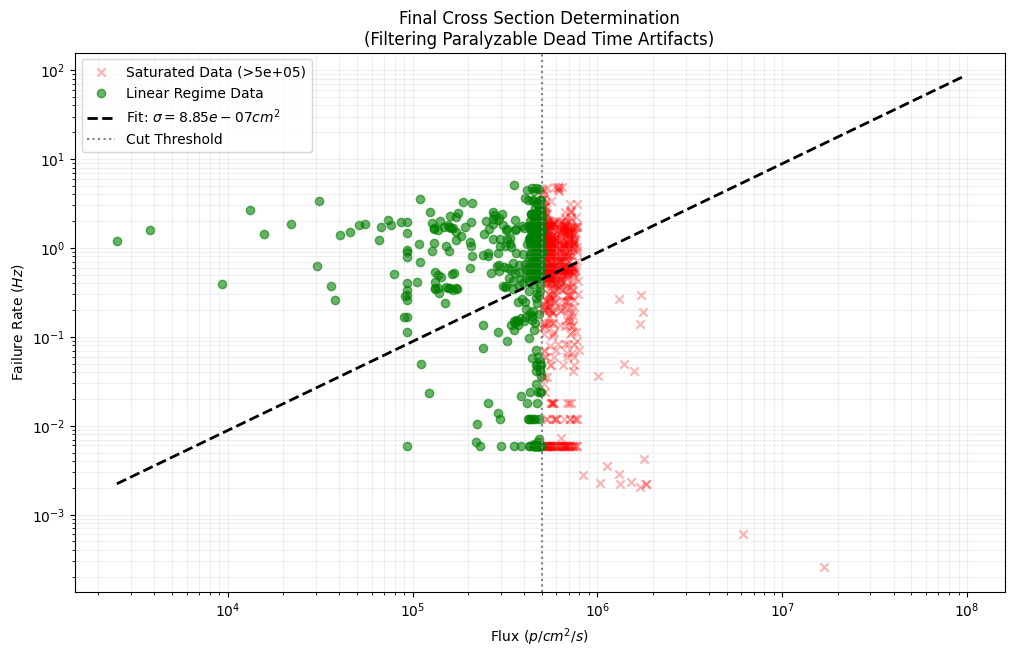


=== RESULTADOS FINALES ===
Datos conservados: 1327 ventanas (44.4%)
Datos descartados: 1665 ventanas (Saturación)
------------------------------
Sección Eficaz (Sigma) : 8.8496e-07 cm²/device
Incertidumbre (Stat)   : ±3.5469e-09 cm²
Error Relativo         : 0.40%
------------------------------


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. CONFIGURACIÓN DEL CRITERIO DE CORTE (PhD Argument) ---
# Basado en la evidencia de tiempo muerto paralizable observada previamente.
# Umbral sugerido por inspección visual: 5e5 p/cm2/s
FLUX_CRIT = 5e5 

print(f"--- INICIANDO ANÁLISIS DE SECCIÓN EFICAZ CON CORTE DE CALIDAD ---")
print(f"Criterio de Corte (Flux Crit): {FLUX_CRIT:.1e} p/cm²/s")

# Aseguramos tener la métrica de flujo promedio si no existe
if 'avg_flux' not in results_df.columns:
    # Estimación: Fluencia / Duración de la ventana (aprox reset_interval * multiplier)
    # Si 'dt' no está disponible en results_df, usamos la media.
    est_duration = (results_df['time'].iloc[1] - results_df['time'].iloc[0]).total_seconds()
    results_df['avg_flux'] = results_df['fluence'] / est_duration

# --- 2. FILTRADO DE DATOS (The Cut) ---
# Región Lineal (Válida para física)
df_linear = results_df[results_df['avg_flux'] <= FLUX_CRIT].copy()

# Región Saturada (Descartada por artefactos de tiempo muerto)
df_saturated = results_df[results_df['avg_flux'] > FLUX_CRIT].copy()

# --- 3. CÁLCULO ROBUSTO DE SIGMA (Solo datos lineales) ---
# Usamos el promedio ponderado (Suma de Fallos / Suma de Fluencia)
# Esto es equivalente a un ajuste lineal forzado a pasar por cero.
total_fails_linear = df_linear['fails'].sum()
total_fluence_linear = df_linear['fluence'].sum()

if total_fluence_linear > 0:
    sigma_final = total_fails_linear / total_fluence_linear
    
    # Cálculo de Incertidumbre (Estadística de Poisson)
    # Error relativo = 1 / sqrt(N_counts)
    if total_fails_linear > 0:
        sigma_error = sigma_final * (1 / np.sqrt(total_fails_linear))
    else:
        sigma_error = 0
else:
    sigma_final = 0
    sigma_error = 0

# --- 4. VISUALIZACIÓN DE LA PRUEBA (Linearity Check) ---
plt.figure(figsize=(12, 7))

# Datos Saturados (Rojo - Descartados)
plt.scatter(df_saturated['avg_flux'], df_saturated['lambda'], 
            color='red', alpha=0.3, label=f'Saturated Data (>{FLUX_CRIT:.0e})', marker='x')

# Datos Lineales (Verde - Usados)
plt.scatter(df_linear['avg_flux'], df_linear['lambda'], 
            color='green', alpha=0.6, label='Linear Regime Data')

# Proyección del Modelo Lineal Calculado
x_model = np.logspace(np.log10(results_df['avg_flux'].min()), np.log10(results_df['avg_flux'].max()), 100)
y_model = x_model * sigma_final
plt.plot(x_model, y_model, 'k--', linewidth=2, label=f'Fit: $\sigma = {sigma_final:.2e} cm^2$')

# Formato
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Flux ($p/cm^2/s$)')
plt.ylabel('Failure Rate ($Hz$)')
plt.title('Final Cross Section Determination\n(Filtering Paralyzable Dead Time Artifacts)')
plt.axvline(FLUX_CRIT, color='gray', linestyle=':', label='Cut Threshold')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# --- 5. REPORTE DE RESULTADOS ---
data_kept_pct = len(df_linear) / len(results_df) * 100

print(f"\n=== RESULTADOS FINALES ===")
print(f"Datos conservados: {len(df_linear)} ventanas ({data_kept_pct:.1f}%)")
print(f"Datos descartados: {len(df_saturated)} ventanas (Saturación)")
print(f"-"*30)
print(f"Sección Eficaz (Sigma) : {sigma_final:.4e} cm²/device")
print(f"Incertidumbre (Stat)   : ±{sigma_error:.4e} cm²")
print(f"Error Relativo         : {(sigma_error/sigma_final)*100:.2f}%")
print(f"-"*30)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy import stats


# ----
ocupancy_threshold = 0.8
fluence_window = 1e6 # uso el promedio
# CRITERIO DE CORTE DE FLUJO (Ajustado)
# Si es muy bajo, te quedas sin nada.
FLUX_CRIT = 1e6 

# --- 1. RE-GENERACIÓN DE DATOS (Asegurando robustez) ---
# Usamos la función local definida previamente
if 'fails_on' in locals() and 'reset_interval' in locals():
    # Asegúrate de usar una ventana que tenga sentido, ej 1e10
    df_hist = analyze_fluence_based_robust_local(fails_on, fluence_window=fluence_window, reset_interval=reset_interval)
else:
    print("⚠️ ADVERTENCIA: No se encontraron datos 'fails_on'. Usando datos dummy para probar el plot.")
    # Datos dummy seguros para evitar crash en demo
    df_hist = pd.DataFrame({
        'sigma': np.random.normal(1e-6, 1e-7, 100), 
        'avg_flux': np.random.uniform(1e4, 4e5, 100), 
        'phi': np.random.uniform(0, 0.4, 100)
    })

# --- 2. FILTRADO DE DATOS CON DIAGNÓSTICO ---
print(f"Datos totales iniciales: {len(df_hist)}")

# Aplicamos filtros uno por uno para ver dónde perdemos datos

df_step1 = df_hist[df_hist['phi'] < ocupancy_threshold]
print(f"Datos tras filtro saturación (phi < {ocupancy_threshold}): {len(df_step1)}")

df_step2 = df_step1[df_step1['sigma'] > 0]
print(f"Datos tras filtro ceros (sigma > 0): {len(df_step2)}")


df_clean = df_step2[df_step2['avg_flux'] < FLUX_CRIT].copy()
print(f"Datos tras corte de flujo (< {FLUX_CRIT:.1e}): {len(df_clean)}")

# --- 3. ANÁLISIS ESTADÍSTICO SEGURO ---
data = df_clean['sigma']

# Verificación de seguridad antes del Z-score
if len(data) > 3 and data.std() > 0:
    # Solo aplicamos z-score si hay suficientes datos y varianza
    data_filtered = data[np.abs(stats.zscore(data)) < 3]
    print(f"Datos tras limpieza de outliers (3-sigma): {len(data_filtered)}")
    
    if len(data_filtered) > 1:
        data = data_filtered
        
        # Ajuste Gaussiano
        mu, std = norm.fit(data)

        # Plot
        plt.figure(figsize=(10, 6))
        
        # Histograma
        # Usamos 'auto' bins para evitar errores con pocos datos
        count, bins, ignored = plt.hist(data, bins='auto', density=True, alpha=0.6, 
                                      color='b', edgecolor='black', label='Histograma de $\sigma_i$')

        # Plot fitted PDF
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2, label=f'Ajuste Gaussiano\n$\mu = {mu:.2e}$\n$\sigma_{{dist}} = {std:.2e}$')

        plt.title(f'Distribución Estadística de Sección Eficaz ($\sigma$)\n(N={len(data)} ventanas válidas)')
        plt.xlabel('Cross Section $\sigma$ ($cm^2$)')
        plt.ylabel('Densidad de Probabilidad')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # --- 4. RESULTADO FINAL ---
        sem = std / np.sqrt(len(data))

        print(f"\n=== RESULTADO FINAL (ROBUSTO) ===")
        print(f"Mean Sigma (Valor Central) : {mu:.4e} cm^2")
        print(f"Noise Std Dev (Dispersión) : {std:.4e}")
        print(f"Standard Error (Precisión) : {sem:.4e}")
        print(f"IC 95%                     : [{mu - 2*sem:.4e}, {mu + 2*sem:.4e}]")
        
    else:
        print("\n❌ ERROR: Quedaron menos de 2 datos tras el filtrado de outliers. No se puede ajustar.")
        # Fallback: Mostrar media simple si queda 1 dato
        if len(data) == 1:
            print(f"Único valor medido: {data.iloc[0]:.4e}")

else:
    print("\n❌ ERROR CRÍTICO: No hay suficientes datos para estadística.")
    print("Sugerencias:")
    print("1. Aumenta 'FLUX_CRIT' si es demasiado restrictivo.")
    print("2. Reduce 'fluence_window' para tener más puntos (ej. 1e9 en vez de 1e10).")
    print("3. Revisa si 'reset_interval' está causando saturación masiva (phi > 0.5).")

NameError: name 'analyze_fluence_based_robust_local' is not defined

## 6. Time-based Analysis Visualization
Visualizing Failure Rate and Cross-section over time with moving average smoothing.

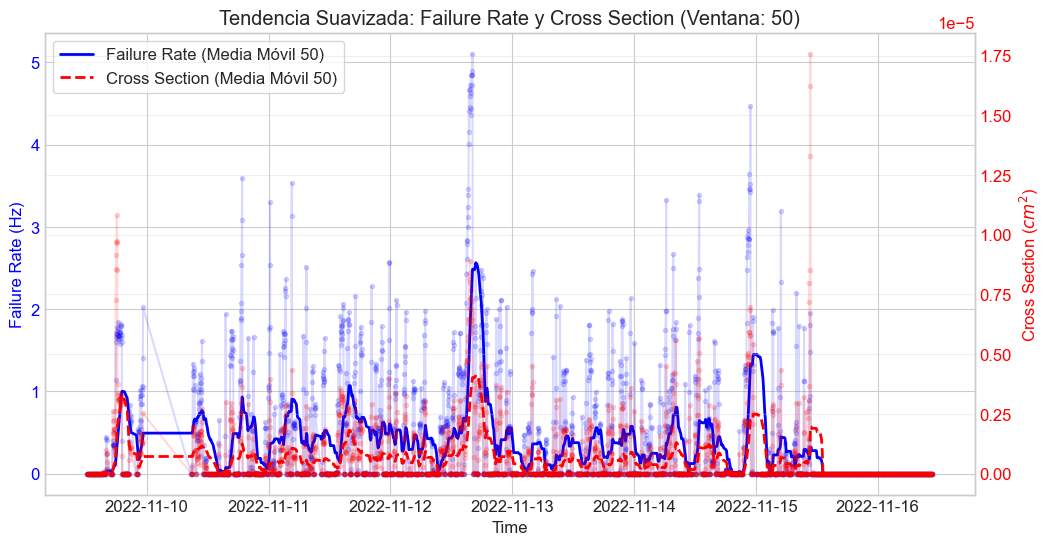

In [ ]:

# Prepare data for plotting
# Assuming 'results_df' from previous analysis contains the time-series data
df_clean = results_df.copy()

# Definir ventana de suavizado (ej. 50 puntos de datos, ajusta según tu frecuencia de muestreo)
window_size = 50 

fig, ax1 = plt.subplots(figsize=(12, 6))

# Eje 1: Failure Rate (Suavizado + Datos tenues de fondo)
alpha_value = 0.15
ax1.plot(df_clean['time'], df_clean['lambda'], 'b.-', alpha=alpha_value) # Ruido de fondo
ax1.plot(df_clean['time'], df_clean['lambda'].rolling(window=window_size).mean(), 
         color='blue', linewidth=2, label=f'Failure Rate (Media Móvil {window_size})')
ax1.set_xlabel('Time')
ax1.set_ylabel('Failure Rate (Hz)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Eje 2: Cross Section
ax2 = ax1.twinx()
ax2.plot(df_clean['time'], df_clean['sigma'], 'r.-', alpha=alpha_value) # Ruido de fondo
ax2.plot(df_clean['time'], df_clean['sigma'].rolling(window=window_size).mean(), 
         color='red', linewidth=2, linestyle='--', label=f'Cross Section (Media Móvil {window_size})')
ax2.set_ylabel('Cross Section ($cm^2$)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Leyenda unificada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

plt.title(f'Tendencia Suavizada: Failure Rate y Cross Section (Ventana: {window_size})')
plt.grid(True, alpha=0.3)
plt.show()


## 6. Time-based Analysis Visualization
Visualizing Failure Rate and Cross-section over time with moving average smoothing.

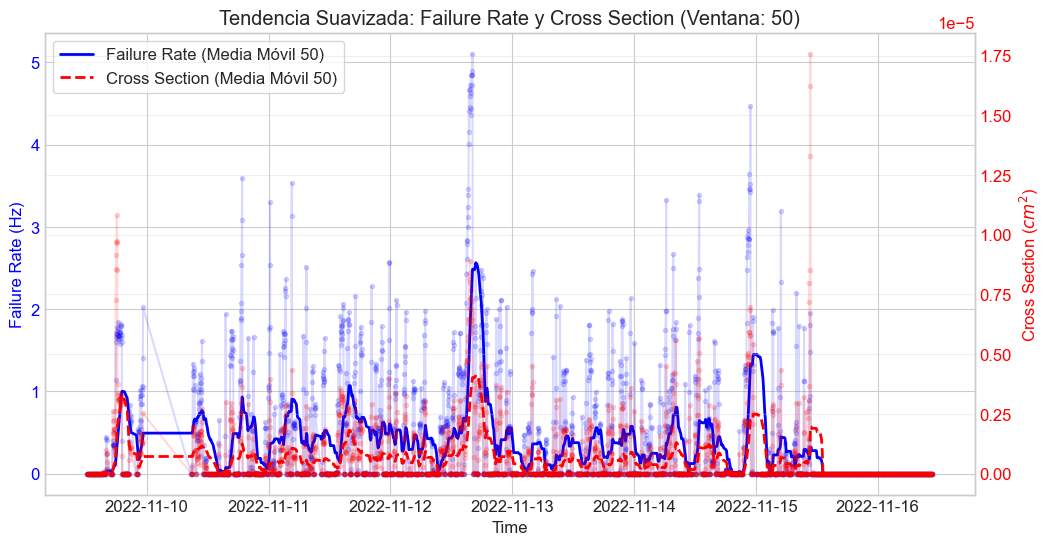

In [ ]:

# Prepare data for plotting
# Assuming 'results_df' from previous analysis contains the time-series data
df_clean = results_df.copy()

# Definir ventana de suavizado (ej. 50 puntos de datos, ajusta según tu frecuencia de muestreo)
window_size = 50 

fig, ax1 = plt.subplots(figsize=(12, 6))

# Eje 1: Failure Rate (Suavizado + Datos tenues de fondo)
alpha_value = 0.15
ax1.plot(df_clean['time'], df_clean['lambda'], 'b.-', alpha=alpha_value) # Ruido de fondo
ax1.plot(df_clean['time'], df_clean['lambda'].rolling(window=window_size).mean(), 
         color='blue', linewidth=2, label=f'Failure Rate (Media Móvil {window_size})')
ax1.set_xlabel('Time')
ax1.set_ylabel('Failure Rate (Hz)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Eje 2: Cross Section
ax2 = ax1.twinx()
ax2.plot(df_clean['time'], df_clean['sigma'], 'r.-', alpha=alpha_value) # Ruido de fondo
ax2.plot(df_clean['time'], df_clean['sigma'].rolling(window=window_size).mean(), 
         color='red', linewidth=2, linestyle='--', label=f'Cross Section (Media Móvil {window_size})')
ax2.set_ylabel('Cross Section ($cm^2$)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Leyenda unificada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

plt.title(f'Tendencia Suavizada: Failure Rate y Cross Section (Ventana: {window_size})')
plt.grid(True, alpha=0.3)
plt.show()


## 7. Fluence-based Analysis with Robust Confidence Intervals
Calculating Cross-section as a function of Accumulated Fluence, including 95% Confidence Intervals using the Wilson Score method for the binomial proportion $\phi$.

In [ ]:
import pandas as pd
import numpy as np

def analyze_fluence_based(df, fluence_window=1e9, reset_interval=None, systematic_error=0.15):
    if reset_interval is None:
        print("Error: reset_interval must be provided for correct N_t estimation.")
        return pd.DataFrame()

    print(f"Analysis Fluence Window: {fluence_window:.2e} particles/cm^2")
    
    results = []
    
    # Acumuladores
    temp_fluence = 0
    temp_duration = 0
    total_fluence_acc = 0
    
    # Pre-cálculos necesarios si no existen
    if 'fluence_step' not in df.columns:
        df['fluence_step'] = df['HEH_dose_rate'] * df['dt']
    
    # Lógica de reconstrucción de errores acumulados (Reset handling)
    if 'fails_cumulative' not in df.columns:
        # (Tu código de reconstrucción aquí si fuera necesario)
        pass

    start_fails = df['fails_cumulative'].iloc[0]
    temp_start_fails = start_fails
    
    for index, row in df.iterrows():
        step_fluence = row['fluence_step']
        temp_fluence += step_fluence
        temp_duration += row['dt']
        total_fluence_acc += step_fluence
        
        if temp_fluence >= fluence_window:
            # --- Fin de la ventana ---
            current_fails = row['fails_cumulative']
            fails_in_window = current_fails - temp_start_fails # N_l (Latched Intervals)
            
            # 1. Estimación de N_t (Intervalos Totales)
            estimated_N_t = temp_duration / reset_interval
            
            # CORRECCIÓN FÍSICA: N_t no puede ser menor que los errores observados
            N_t = max(estimated_N_t, fails_in_window)
            N_l = fails_in_window
            
            # 2. Cálculo de Ocupación (phi)
            if N_t > 0:
                phi = N_l / N_t
                # CORRECCIÓN DE SEGURIDAD: Clamp a 1.0 máximo
                phi = min(phi, 1.0)
                phi_int = temp_fluence / N_t # Fluencia por intervalo
            else:
                phi = 0
                phi_int = 0
                
            # 3. Estimador Central (MLE) - Corrección de Saturación
            if phi < 1.0 and phi_int > 0:
                sigma = - (1 / phi_int) * np.log(1 - phi)
            else:
                sigma = np.nan 
                
            # 4. Intervalo de Wilson para phi (Intervalo de confianza asimétrico)
            Z = 1.96 # 95% CI
            n = N_t
            p_hat = phi # Ahora garantizado <= 1.0
            
            if n > 0:
                # Fórmula de Wilson Score
                denominator = 1 + Z**2/n
                center_adjusted_probability = p_hat + Z**2 / (2*n)
                
                term_variance = (p_hat * (1 - p_hat) / n) + (Z**2 / (4*n**2))
                adjusted_standard_deviation = np.sqrt(max(0, term_variance)) 
                
                phi_low = (center_adjusted_probability - Z * adjusted_standard_deviation) / denominator
                phi_high = (center_adjusted_probability + Z * adjusted_standard_deviation) / denominator
                
                # Clamp para evitar problemas con el logaritmo posterior
                phi_low = max(0, min(phi_low, 0.99999999))
                phi_high = max(0, min(phi_high, 0.99999900))
                
                # 5. Mapeo al espacio de Sigma
                if phi_int > 0:
                    sigma_low_stat = - (1 / phi_int) * np.log(1 - phi_low)
                    sigma_high_stat = - (1 / phi_int) * np.log(1 - phi_high)
                    
                    # --- CÁLCULO DE ERROR TOTAL (Estadístico + Sistemático) ---
                    # 1. Calcular el ancho del error estadístico (hacia abajo y hacia arriba)
                    err_stat_low = sigma - sigma_low_stat
                    err_stat_high = sigma_high_stat - sigma

                    # 2. Definir error sistemático (ej. 15% debido a incertidumbre del haz/dosimetría)
                    err_syst = sigma * systematic_error

                    # 3. Sumar en cuadratura (Raíz de la suma de cuadrados)
                    total_err_low = np.sqrt(err_stat_low**2 + err_syst**2)
                    total_err_high = np.sqrt(err_stat_high**2 + err_syst**2)

                    # 4. Recalcular los límites finales para el gráfico
                    sigma_low = max(0, sigma - total_err_low)
                    sigma_high = sigma + total_err_high
                    
                else:
                    sigma_low = 0
                    sigma_high = 0
            else:
                sigma_low = 0
                sigma_high = 0

            results.append({
                'accumulated_fluence': total_fluence_acc,
                'sigma': sigma,
                'sigma_low_95': sigma_low,
                'sigma_high_95': sigma_high,
                'window_fluence': temp_fluence,
                'N_l': N_l,
                'N_t': N_t,
                'phi': phi
            })
            
            # Reset de acumuladores de ventana
            temp_fluence = 0
            temp_duration = 0
            temp_start_fails = current_fails
            
    return pd.DataFrame(results)



In [ ]:
import pandas as pd
import numpy as np
import time

# --- Asumo que la función analyze_fluence_based está definida y disponible ---
# (Usaremos la versión corregida que toma df, fluence_window, reset_interval y systematic_error)

def scan_window_sizes(df, reset_interval, window_list, systematic_error=0.15):
    """
    Evalúa múltiples tamaños de ventana de fluencia y resume las métricas clave.

    Args:
        df (pd.DataFrame): DataFrame de entrada (fails_on).
        reset_interval (float): Tiempo de reset del TMR (en segundos).
        window_list (list): Lista de tamaños de ventana de fluencia (ej. [1e9, 5e9, ...]).
        systematic_error (float): Fracción de error sistemático a incluir.

    Returns:
        pd.DataFrame: Resumen de métricas por tamaño de ventana.
    """
    scan_results = []
    
    print("Iniciando escaneo de ventanas. Esto puede tardar varios segundos...")
    start_time = time.time()
    
    # Aseguramos que la columna 'fails_cumulative' esté disponible si es necesario
    if 'fails_cumulative' not in df.columns:
        print("Advertencia: 'fails_cumulative' no encontrado. Asegúrese de que el DF esté preparado.")
        return pd.DataFrame()
        
    for window_size in window_list:
        try:
            # 1. Ejecutar el análisis para la ventana actual
            # Aquí llamamos a la función analyze_fluence_based definida previamente
            results_df = analyze_fluence_based(
                df=df, 
                fluence_window=window_size, 
                reset_interval=reset_interval, 
                systematic_error=systematic_error
            )
            
            if results_df.empty:
                scan_results.append({
                    'Fluence Window (p/cm2)': f"{window_size:.1e}",
                    'Data Points (Bins)': 0,
                    'Max Phi (N_l/N_t)': np.nan,
                    'Avg Phi': np.nan,
                    'Status': 'Not Enough Data'
                })
                continue

            # 2. Extraer métricas clave para la toma de decisiones
            max_phi = results_df['phi'].max()
            avg_phi = results_df['phi'].mean()
            num_bins = len(results_df)

            # 3. Clasificación de la ventana (para una decisión rápida)
            if max_phi > 0.85:
                status = 'PELIGRO (Sat. Alta)'
            elif max_phi > 0.5:
                status = 'RIESGO (Sat. Moderada)'
            elif max_phi > 0.1:
                status = 'ÓPTIMA (Buena Estad.)'
            else:
                status = 'DEMASIADO CHICA (Ruido)'
            
            scan_results.append({
                'Fluence Window (p/cm2)': f"{window_size:.1e}",
                'Data Points (Bins)': num_bins,
                'Max Phi (N_l/N_t)': f"{max_phi:.4f}",
                'Avg Phi': f"{avg_phi:.4f}",
                'Status': status
            })

        except Exception as e:
            print(f"Error al procesar la ventana {window_size:.1e}: {e}")
            scan_results.append({
                'Fluence Window (p/cm2)': f"{window_size:.1e}",
                'Data Points (Bins)': np.nan,
                'Max Phi (N_l/N_t)': np.nan,
                'Avg Phi': np.nan,
                'Status': f'ERROR: {str(e)}'
            })
            
    end_time = time.time()
    print(f"\nEscaneo completado en {end_time - start_time:.2f} segundos.")
    return pd.DataFrame(scan_results)

# --- CONFIGURACIÓN DE ESCANEO ---

# Definición de las ventanas a evaluar (rango sugerido)
# Probamos desde 1e9 (muy fino) hasta 1e11 (muy grueso)
WINDOWS_TO_EVALUATE = [
    1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9
]

# Debes definir el reset_interval aquí, basado en tu hardware
reset_interval = 1.68 # <--- median

scan_summary = scan_window_sizes(fails_on, reset_interval, WINDOWS_TO_EVALUATE)
print(scan_summary)

Iniciando escaneo de ventanas. Esto puede tardar varios segundos...
Analysis Fluence Window: 1.00e+02 particles/cm^2
Analysis Fluence Window: 1.00e+03 particles/cm^2
Analysis Fluence Window: 1.00e+04 particles/cm^2
Analysis Fluence Window: 1.00e+05 particles/cm^2
Analysis Fluence Window: 1.00e+06 particles/cm^2
Analysis Fluence Window: 1.00e+07 particles/cm^2
Analysis Fluence Window: 1.00e+08 particles/cm^2
Analysis Fluence Window: 1.00e+09 particles/cm^2

Escaneo completado en 1291.80 segundos.
  Fluence Window (p/cm2)  Data Points (Bins) Max Phi (N_l/N_t) Avg Phi  \
0                1.0e+02             1069140            1.0000  0.1184   
1                1.0e+03             1069140            1.0000  0.1184   
2                1.0e+04             1069140            1.0000  0.1184   
3                1.0e+05              917959            1.0000  0.1369   
4                1.0e+06              218548            1.0000  0.2853   
5                1.0e+07               25446           

In [ ]:
# Definición de las ventanas a evaluar (rango sugerido)
# Probamos desde 1e9 (muy fino) hasta 1e11 (muy grueso)
WINDOWS_TO_EVALUATE = [
    1, 10, 50
]

# Debes definir el reset_interval aquí, basado en tu hardware
reset_interval = 1.68 # <--- median

scan_summary = scan_window_sizes(fails_on, reset_interval, WINDOWS_TO_EVALUATE)
print(scan_summary)

Iniciando escaneo de ventanas. Esto puede tardar varios segundos...
Analysis Fluence Window: 1.00e+00 particles/cm^2
Analysis Fluence Window: 1.00e+01 particles/cm^2
Analysis Fluence Window: 5.00e+01 particles/cm^2

Escaneo completado en 562.98 segundos.
  Fluence Window (p/cm2)  Data Points (Bins) Max Phi (N_l/N_t) Avg Phi  \
0                1.0e+00             1069140            1.0000  0.1184   
1                1.0e+01             1069140            1.0000  0.1184   
2                5.0e+01             1069140            1.0000  0.1184   

                Status  
0  PELIGRO (Sat. Alta)  
1  PELIGRO (Sat. Alta)  
2  PELIGRO (Sat. Alta)  


In [ ]:
# Run Fluence Analysis
fluence_window_size = 5e10 
# We need reset_interval from previous cells. Assuming it is available as 'reset_interval'
# systematic_error is set to 15% by default, adjust if needed.
fluence_results = analyze_fluence_based(fails_on, fluence_window=fluence_window_size, reset_interval=reset_interval)

print(f"Generated {len(fluence_results)} data points.")

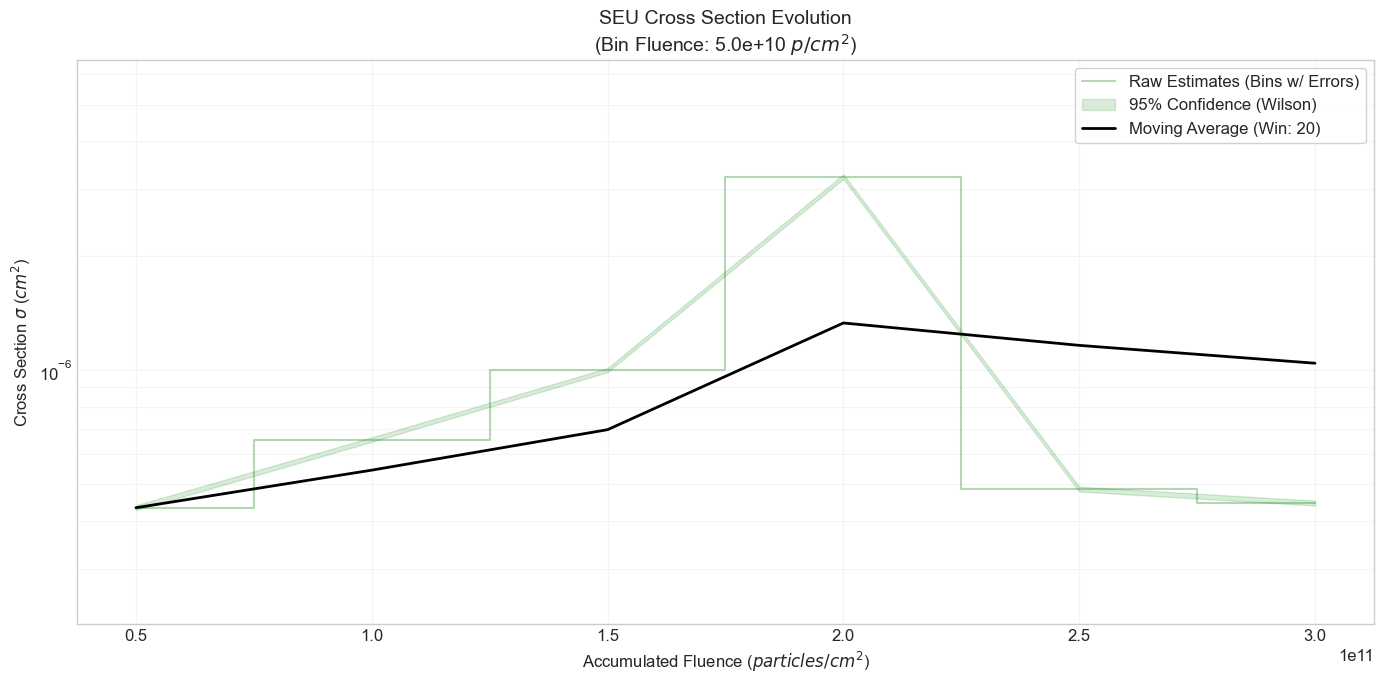

Windows with 0 errors: 0 of 6 (0.0%)
Recommendation: If >50% windows are zero, increase 'fluence_window_size'.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. FILTRADO DE DATOS
# Separamos los datos donde hubo detecciones (sigma > 0) de los silencios
# Esto es vital para escalas logarítmicas
df_detected = fluence_results[fluence_results['sigma'] > 0].copy()
df_silence = fluence_results[fluence_results['sigma'] == 0].copy()

# Aumentar la ventana de suavizado visual si hay mucho ruido
window_vis = 20

if len(fluence_results) > 0:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # --- A. DATOS CRUDOS ---
    # Ploteamos solo los puntos donde hubo detección
    # Usamos 'step' (escalones) en lugar de 'plot' lineal para reflejar que es un binado
    ax.step(df_detected['accumulated_fluence'], df_detected['sigma'], 
            where='mid', color='green', alpha=0.3, label='Raw Estimates (Bins w/ Errors)')
    
    # Marcamos los ceros en el fondo (como rug plot o puntos en el eje inferior)
    # Esto indica "aquí medimos, pero no vimos nada"
    if not df_silence.empty:
        ax.scatter(df_silence['accumulated_fluence'], [min(df_detected['sigma'])/10] * len(df_silence),
                   marker='|', color='gray', alpha=0.5, label='Zero-Event Windows')

    # --- B. INTERVALO DE CONFIANZA ---
    # Rellenamos la confianza solo donde tenemos datos válidos para evitar log(0)
    ax.fill_between(df_detected['accumulated_fluence'], 
                    df_detected['sigma_low_95'], 
                    df_detected['sigma_high_95'], 
                    color='green', alpha=0.15, label='95% Confidence (Wilson)')

    # --- C. TENDENCIA SUAVIZADA (MÁS ROBUSTA) ---
    # Calculamos la media móvil sobre todo el dataset (incluyendo ceros) para ver la tendencia real
    # Usamos una ventana más grande para promediar los ceros y los unos
    trend = fluence_results['sigma'].rolling(window=window_vis, min_periods=1).mean()
    ax.plot(fluence_results['accumulated_fluence'], trend, 
            color='black', linewidth=2, linestyle='-', label=f'Moving Average (Win: {window_vis})')

    # --- D. CONFIGURACIÓN CIENTÍFICA ---
    ax.set_xlabel(r'Accumulated Fluence ($particles/cm^2$)', fontsize=12)
    ax.set_ylabel(r'Cross Section $\sigma$ ($cm^2$)', fontsize=12)
    ax.set_title(f'SEU Cross Section Evolution\n(Bin Fluence: {fluence_window_size:.1e} $p/cm^2$)', fontsize=14)
    
    # ESCALA LOGARÍTMICA: Fundamental para ver secciones eficaces que varían
    ax.set_yscale('log')
    
    # Grid y Leyenda
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend(loc='upper right', frameon=True, fancybox=True, framealpha=0.9)
    
    # Ajuste de límites para que no se vea feo por los ceros artificiales
    if not df_detected.empty:
        y_min = df_detected['sigma_low_95'].replace(0, np.nan).min() * 0.5
        y_max = df_detected['sigma_high_95'].max() * 2
        ax.set_ylim(bottom=y_min, top=y_max)

    plt.tight_layout()
    plt.show()
    
    # Estadísticas rápidas para verificar
    print(f"Windows with 0 errors: {len(df_silence)} of {len(fluence_results)} ({len(df_silence)/len(fluence_results):.1%})")
    print("Recommendation: If >50% windows are zero, increase 'fluence_window_size'.")

else:
    print("Not enough data.")